![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Processos Hospitalares

Neste documento investigamos a dinâmica dos processos hospitalares frente à COVID19. Esta implementação serve como base para investigações mais profundas, e pode ser customizada e usado de diversos modos por eventuais interessados. Veremos ao final algumas idéias práticas de como fazer isso.

**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [4]:
import os
import math
import hyperopt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [5]:
plt.style.use('fivethirtyeight')

Se necessário, ajuste o diretório de trabalho para ser o que contém este *notebook*.

In [6]:
print(os.getcwd())
os.chdir('covid19-analytics/notebooks')
os.getcwd()

/root


'/root/covid19-analytics/notebooks'

## Parâmetros das Simulações

Empregaremos simulações para efetivamente executar os modelos que serão desenvolvidos abaixo. Para tanto, é necessário definir-se alguns parâmetros gerais.

**Início e duração** serão inferidos a partir dos dados de entrada, portanto não são definidos aqui como parâmetros.

In [7]:
target_location = 'Brazil'

### Estrutura Hospitalar

In [8]:
total_er_capacity = 10000 # TODO check

In [9]:
total_hospital_capacity = 435000 # TODO check

In [10]:
total_icu_capacity = 41000 # TODO check

### Suposições Clínicas

Probabilidades de se necessitar de uma internação ou UTI.

In [11]:
p_require_hospitalization_no_icu = 0.2

In [12]:
p_require_icu = 0.05

Probabilidades de óbito em internação ou UTI.

In [13]:
p_death_hospitalization_no_icu = 0.05 

In [14]:
p_death_icu = 0.5

Tempo médio de hospitalização (em UTI ou não) para quem irá sobreviver e quem não irá. Sabe-se que esses tempos diferem consideravelmente, o que justifica esta distinção no modelo.

In [15]:
mean_duration_hospitalization_no_icu_survivors = 5 # TODO check

In [16]:
mean_duration_hospitalization_no_icu_dead = 5  # TODO check

In [17]:
mean_duration_icu_survivors = 21

In [18]:
mean_duration_icu_dead = 7

### Resultados

Onde queremos armazenar resultados do modelo para posterior.

In [19]:
results_folder = '../results/'

## Funções Gerais

Iremos definir algumas funções para facilitar o desenho de gráficos.

In [20]:
def plot_simulation_output(df_simulated_data_by_date, 
                           total_er_capacity=total_er_capacity, 
                           total_hospital_capacity=total_hospital_capacity,
                           total_icu_capacity=total_icu_capacity,
                           zoom_on=None,
                           zoom_length=60):
    
    ax = sns.lineplot(data=df_simulated_data_by_date)
    ax.set_title('Dados Completos')
    plt.figure()
    
    if zoom_on is not None:
        zoom_end = (pd.Timestamp(zoom_on) + pd.DateOffset(days=zoom_length)).date()
        ax = sns.lineplot(data=df_simulated_data_by_date[zoom_on:zoom_end])
        ax.set_title(f'Zoom (de {zoom_on} a {zoom_end})')
        plt.figure()
    
    # Internações
    ax = sns.lineplot(data=df_simulated_data_by_date[['new_patients', 'hospitalized', 'icu']])
    ax.set_title('Infectados, Internações e Uso de UTIs')
    plt.figure()
    
    # ICU
    ax = sns.lineplot(data=df_simulated_data_by_date[['icu']])
    ax.axhline(total_icu_capacity, ls='--')
    ax.set_title('Uso de UTIs Esperado e Capacidade total')

In [21]:
def plot_input_data(df_input_data,zoom_on=None, zoom_length=60):
    df_input_data = df_input_data[['E', 'I', 'I_delta']]
    
    ax = sns.lineplot(data=df_input_data)
    ax.set_title('Visão Geral da Epidemia')
    plt.figure()
    
    if zoom_on is not None:
        zoom_end = (pd.Timestamp(zoom_on) + pd.DateOffset(days=zoom_length)).date()
        ax = sns.lineplot(data=df_input_data[zoom_on:zoom_end], markers=True)
        ax.set_title(f'Zoom (de {zoom_on} a {zoom_end})')
        plt.figure()

## Dados de Entrada

Os processos aqui modelados dependem de dados sobre o progresso da epidemia *fora dos hospitais*. Assim, iremos supor que essa informação está disponível em um arquivo externo, que é lido abaixo. Note que esses dados podem ser tantos reais quanto projetados via modelos.

In [22]:
df_input_data = pd.read_csv(f'../results/seir_dynamic_model_output.{target_location.lower()}.csv', index_col=[0], parse_dates=True)
df_input_data.head()

,S,E,E_delta,I,I_delta,R,R_delta,E+I,E+I+R
2020-03-12,2.125594e+08,52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52.000000,52.000000
2020-03-13,2.125594e+08,0.476215,0.000000,51.523785,51.523785,0.000000,0.000000,52.000000,52.000000
2020-03-14,2.125593e+08,48.840944,48.836583,51.078096,0.471854,0.917543,0.917543,99.919040,100.836583
2020-03-15,2.125593e+08,48.861411,48.414127,98.562149,48.393660,1.827149,0.909606,147.423561,149.250710
2020-03-16,2.125592e+08,93.869109,93.421638,145.220880,48.413940,3.582359,1.755209,239.089989,242.672348


Vejamos esses números como gráficos.

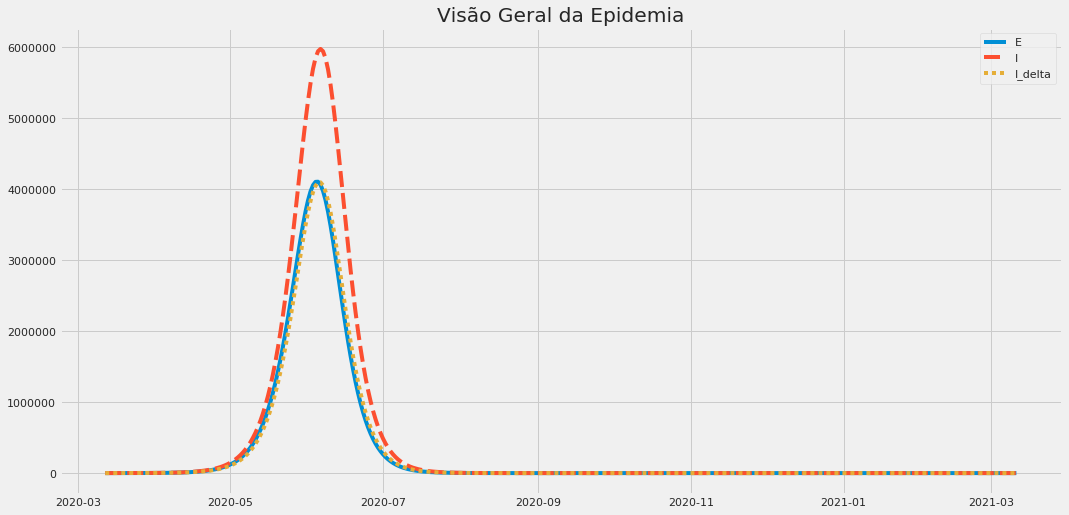

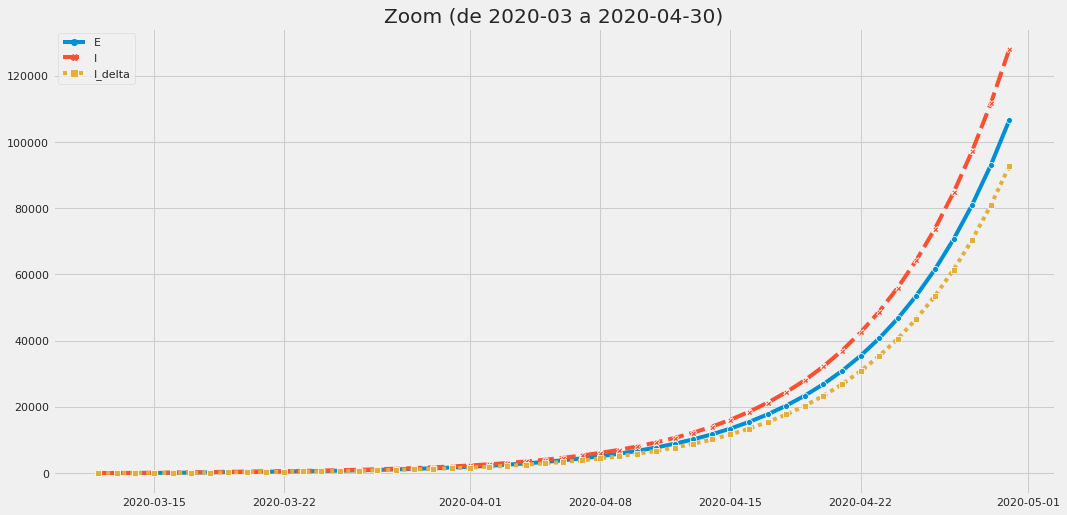

<Figure size 1152x576 with 0 Axes>

In [23]:
plot_input_data(df_input_data, zoom_on='2020-03')

## Processos Hospitalares

A simulação dos processos hospitalares é a o núcleo do modelo aqui descrito. 

### Funções Auxiliares

Antes de prosseguir, precisamos de algumas funções auxiliares para definirmos os processos desejados de modo mais sucinto.

In [24]:
def perform_step_once(func, step_name, cohort_id, cohort_data, next_cohort_data, control_data):
    step_key = f'{step_name}_step_performed'
    performed = control_data[cohort_id].get(step_key, False)
    
    if not performed:
        func(cohort_data, next_cohort_data)
        
        # remember that the step was performed
        control_data[cohort_id][step_key] = True

In [25]:
def schedule_step_once_for(t_target, step_name, cohort_id, control_data):
    key = f'{step_name}_step_scheduled_time'
    if key not in control_data[cohort_id]:
        control_data[cohort_id][key] = t_target

In [26]:
def is_time_for_step(t, step_name, cohort_id, control_data):
    key = f'{step_name}_step_scheduled_time'
    t_target = control_data[cohort_id][key]
    res = (t == t_target)

    return res

In [27]:
def store_control_variable_once(name, value, cohort_id, control_data):
    key = f'{name}_control_variable'
    if key not in control_data[cohort_id]:
        control_data[cohort_id][key] = value

In [28]:
def get_control_value(name, cohort_id, control_data):
    key = f'{name}_control_variable'
    return control_data[cohort_id][key]

## Processos Principais

A dinâmica hospitalar modelada segue uma sequência de passos que são aplicados a um conjunto de coortes. Cada coorte representa um grupo de *novos pacientes* que surge em um momento específico. Separando-se os pacientes assim, o fluxo pelos processos hospitalares pode ser calculado independentemente em cada coorte.  

Cada passo no processo hospitalar é definido por uma função específica prefixada por `process_` e que aplica as transformações necessárias ao coorte especificado. A primeira função é a única exceção, posto que ela *cria* um novo coorte para ser admitido no hospital.

In [29]:
def process_admit_cohort(t, date, newly_infected):
    cohort = {'t': t,
              't_admitted': t, 
              'date': date,
              'new_patients': newly_infected,
              'er': 0,
              'hospitalized': 0,
              'icu': 0,
              'recovered': 0, 
              'dead':0}
    
    return cohort

As próximas funções definem a passagem do coorte por:
  - Pronto-Socorro: No modelo atual, esta etapa é imediata e apenas seleciona os pacientes que serão internados.
  - Internação: Internação (não UTI), que pode evoluir para uso de UTI, alta ou óbito.
  - UTI: Pode evoluir para alta ou óbito.

In [30]:
def process_er(t, cohort_data, hospital_data, control_data):
    next_cohort_data, next_hospital_data = cohort_data.copy(), hospital_data.copy()
    t_admitted = cohort_data['t_admitted']
    
    def step_move_to_hospitalization_no_icu(cohort_data, next_cohort_data):    
        next_cohort_data['new_patients'] = 0
        next_cohort_data['er'] = 0
        next_cohort_data['hospitalized'] = p_require_hospitalization_no_icu * cohort_data['new_patients']
        
    # TODO improve ER process
    perform_step_once(step_move_to_hospitalization_no_icu, 'move_er_to_hospitalization_no_icu', 
                      t_admitted, cohort_data, next_cohort_data, control_data)
    
    return next_cohort_data, next_hospital_data

In [31]:
def process_hospitalization_no_icu(t, cohort_data, hospital_data, control_data):
    next_cohort_data, next_hospital_data = cohort_data.copy(), hospital_data.copy()
    t_admitted = cohort_data['t_admitted']
    
    def step_move_to_icu(cohort_data, next_cohort_data):
        move = get_control_value('hospitalization_no_icu_to_icu_qty', t_admitted, control_data)
        next_cohort_data['hospitalized'] = next_cohort_data['hospitalized'] - move
        next_cohort_data['icu'] =  next_cohort_data['icu'] + move
        store_control_variable_once('t_hosptialization_to_icu', t, t_admitted, control_data)
        
    def step_move_to_recovery(cohort_data, next_cohort_data):
        recovered = get_control_value('hospitalization_no_icu_to_recovery_qty', t_admitted, control_data)
        next_cohort_data['recovered'] = next_cohort_data['recovered'] + recovered
        next_cohort_data['hospitalized'] = next_cohort_data['hospitalized'] - recovered
    
    def step_move_to_death(cohort_data, next_cohort_data):
        dead = get_control_value('hospitalization_no_icu_to_death_qty', t_admitted, control_data)
        next_cohort_data['dead'] = next_cohort_data['dead'] + dead
        next_cohort_data['hospitalized'] = next_cohort_data['hospitalized'] - dead
    
    ##############################
    # Calculate subgroups' size
    ##############################
    
    # the p_require_icu probability refers to the total infected population, so we must adjust the multiplier here to account for
    # the fact that p_require_hospitalization_no_icu were already selected for hospitalization.
    will_go_to_icu = (p_require_icu/p_require_hospitalization_no_icu) * cohort_data['hospitalized']
    
    will_stay_in_hospitalization_no_icu = cohort_data['hospitalized'] - will_go_to_icu
    store_control_variable_once('hospitalization_no_icu_to_icu_qty', will_go_to_icu, 
                                t_admitted, control_data)
    store_control_variable_once('hospitalization_no_icu_to_recovery_qty', 
                                (1 - p_death_hospitalization_no_icu) * will_stay_in_hospitalization_no_icu, 
                                t_admitted, control_data)
    store_control_variable_once('hospitalization_no_icu_to_death_qty', p_death_hospitalization_no_icu * will_stay_in_hospitalization_no_icu, 
                                t_admitted, control_data)
    #########
    # To ICU
    #########
    perform_step_once(step_move_to_icu, 'move_hospitalization_no_icu_to_icu', 
                      t_admitted, cohort_data, next_cohort_data, control_data)
    
    ##############
    # To recovery
    ##############
    schedule_step_once_for(t + mean_duration_hospitalization_no_icu_survivors, 
                           'move_hospitalization_no_icu_to_recovery',t_admitted, control_data)
    if is_time_for_step(t, 'move_hospitalization_no_icu_to_recovery', t_admitted, control_data):
        perform_step_once(step_move_to_recovery, 'move_hospitalization_no_icu_to_recovery', t_admitted, 
                          cohort_data, next_cohort_data, control_data)
    
    ###########
    # To death
    ###########
    schedule_step_once_for(t + mean_duration_hospitalization_no_icu_dead, 'move_hospitalization_no_icu_to_death',t_admitted, control_data)
    if is_time_for_step(t, 'move_hospitalization_no_icu_to_death', t_admitted, control_data):
        perform_step_once(step_move_to_death, 'move_hospitalization_no_icu_to_death', t_admitted, 
                          cohort_data, next_cohort_data, control_data)
    
    return next_cohort_data, next_hospital_data

In [32]:
def process_icu(t, cohort_data, hospital_data, control_data):
    next_cohort_data, next_hospital_data = cohort_data.copy(), hospital_data.copy()
    t_admitted = cohort_data['t_admitted']
            
    def step_move_to_recovery(cohort_data, next_cohort_data):
        recovered = get_control_value('icu_to_recovery_qty', t_admitted, control_data)
        next_cohort_data['recovered'] = next_cohort_data['recovered'] + recovered
        next_cohort_data['icu'] = next_cohort_data['icu'] - recovered
        
    
    def step_move_to_death(cohort_data, next_cohort_data):
        dead = get_control_value('icu_to_death_qty', t_admitted, control_data)
        next_cohort_data['dead'] = next_cohort_data['dead'] + dead
        next_cohort_data['icu'] = next_cohort_data['icu'] - dead
    
    # calculate subgroups
    store_control_variable_once('icu_to_recovery_qty', (1 - p_death_icu) * next_cohort_data['icu'], 
                                t_admitted, control_data)
    store_control_variable_once('icu_to_death_qty', p_death_icu * next_cohort_data['icu'], 
                                t_admitted, control_data)
    
    t_hosptialization_to_icu = get_control_value('t_hosptialization_to_icu', t_admitted, control_data)
    
    ##############
    # To recovery
    ##############
    schedule_step_once_for(t_hosptialization_to_icu + mean_duration_icu_survivors, 'move_icu_to_recovery',t_admitted, control_data)
    if is_time_for_step(t, 'move_icu_to_recovery', t_admitted, control_data):
        perform_step_once(step_move_to_recovery, 'move_icu_to_recovery', t_admitted, 
                          cohort_data, next_cohort_data, control_data)
    
    ###########
    # To death
    ###########
    schedule_step_once_for(t_hosptialization_to_icu + mean_duration_icu_dead, 'move_icu_to_death',t_admitted, control_data)
    if is_time_for_step(t, 'move_icu_to_death', t_admitted, control_data):
        perform_step_once(step_move_to_death, 'move_icu_to_death', t_admitted, 
                          cohort_data, next_cohort_data, control_data)

    
    return next_cohort_data, next_hospital_data

In [33]:
def process_recovery(t, cohort_data, hospital_data, control_data):
    next_cohort_data, next_hospital_data = cohort_data.copy(), hospital_data.copy()
    
    # nothing for now
    
    return next_cohort_data, next_hospital_data

In [34]:
def process_death(t, cohort_data, hospital_data, control_data):
    next_cohort_data, next_hospital_data = cohort_data.copy(), hospital_data.copy()
    
    # nothing for now
    
    return next_cohort_data, next_hospital_data

## Simulação

A simulação dos processos se dá com base nos dados de entrada lidos. Sequencialmente, para cada data: (i) é criado um novo coorte; e (ii) os coortes existentes são atualizados mediante aplicação das funções de processo definidas acima. 

In [35]:
def simulate_hospital(df_input_data):
    
    historical_cohorts = []
    current_cohorts = []
    
    # state of the hospital
    hospital_data = {'total_er_capacity': total_er_capacity,
                     'total_hospital_capacity': total_hospital_capacity, 
                     'total_icu_capacity': total_icu_capacity,
                     'used_er_capacity'
                     'used_hospital_capacity': 0,
                     'used_icus_capacity': 0}
    
    # control variables to aid in process coordination
    control_data = {}
    
    for t, date in enumerate(df_input_data.index):
        row = df_input_data.loc[date]
        
        # create new cohort for the recent infections
        newly_infected = row['I_delta']
        new_cohort_data = process_admit_cohort(t, date, newly_infected)
        current_cohorts.append(new_cohort_data)
        control_data[t] = {}
        
        # preserve current cohorts in historical records
        historical_cohorts = historical_cohorts + [c.copy() for c in current_cohorts]
        
        # update existing cohorts
        next_cohorts = []
        for cohort_data in current_cohorts:
            cohort_data['t'] = t
            cohort_data['date'] = date
            cohort_data, hospital_data = process_er(t, cohort_data, hospital_data, control_data)
            cohort_data, hospital_data = process_hospitalization_no_icu(t, cohort_data, hospital_data, control_data)
            cohort_data, hospital_data = process_icu(t, cohort_data, hospital_data, control_data)
            cohort_data, hospital_data = process_recovery(t, cohort_data, hospital_data, control_data)
            cohort_data, hospital_data = process_death(t, cohort_data, hospital_data, control_data)
            
            next_cohorts.append(cohort_data)
        
        # lockstep update
        current_cohorts = next_cohorts
        next_cohorts = []
            
    df_simulation_data = pd.DataFrame(historical_cohorts)[:-1]
    
    
    df_simulated_data_by_date = \
        df_simulation_data[['date', 'new_patients', 'er', 'hospitalized', 'icu', 'recovered', 'dead']].groupby('date').sum()
    
    return df_simulated_data_by_date, df_simulation_data

Simulemos então com os dados epidemiológicos de entrada.

In [36]:
df_simulated_data_by_date, df_simulation_data = simulate_hospital(df_input_data)

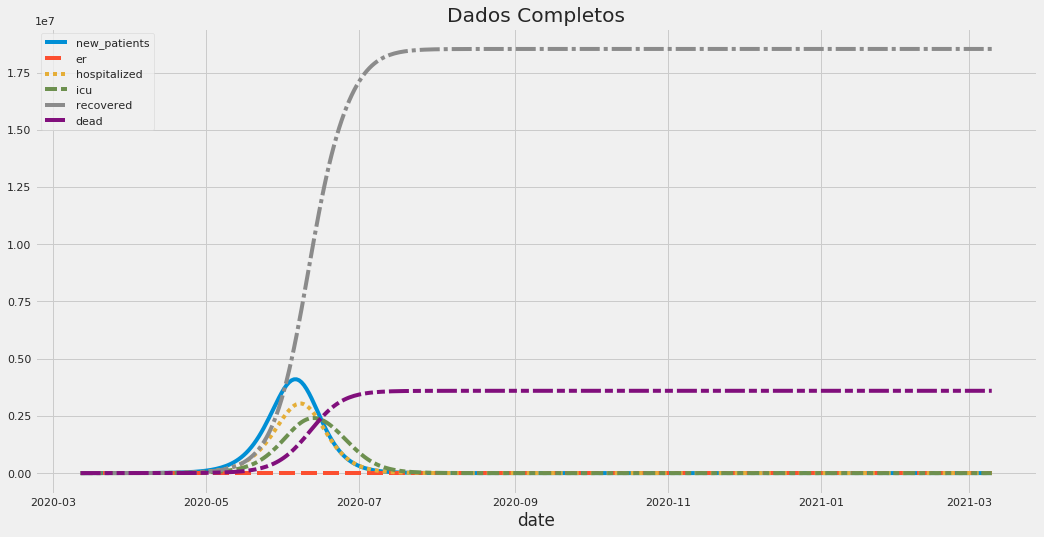

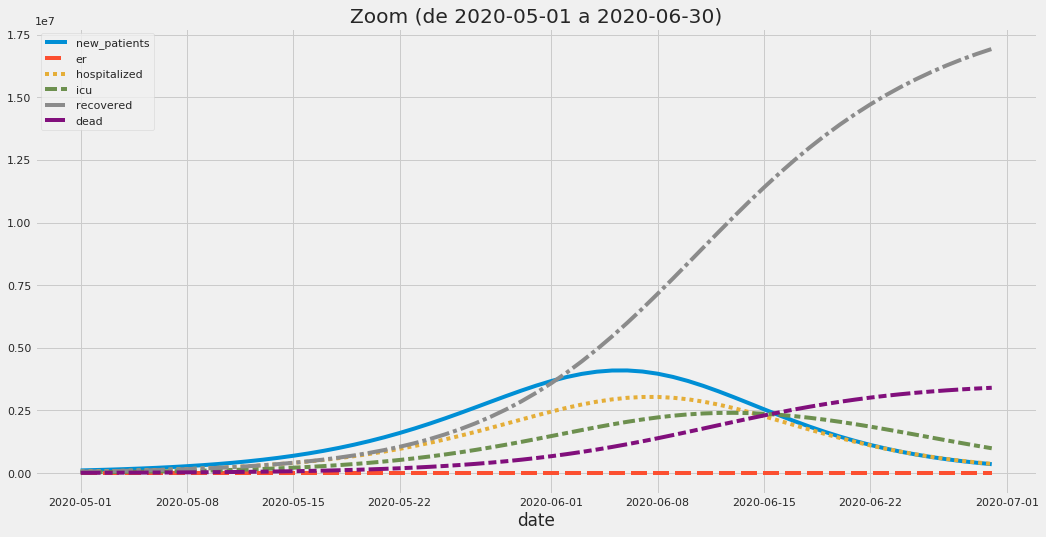

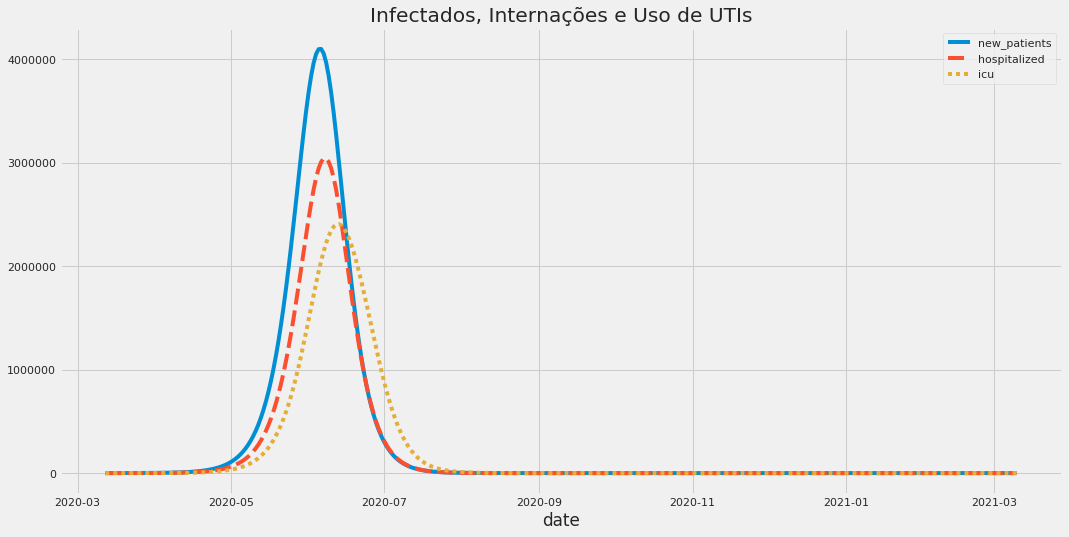

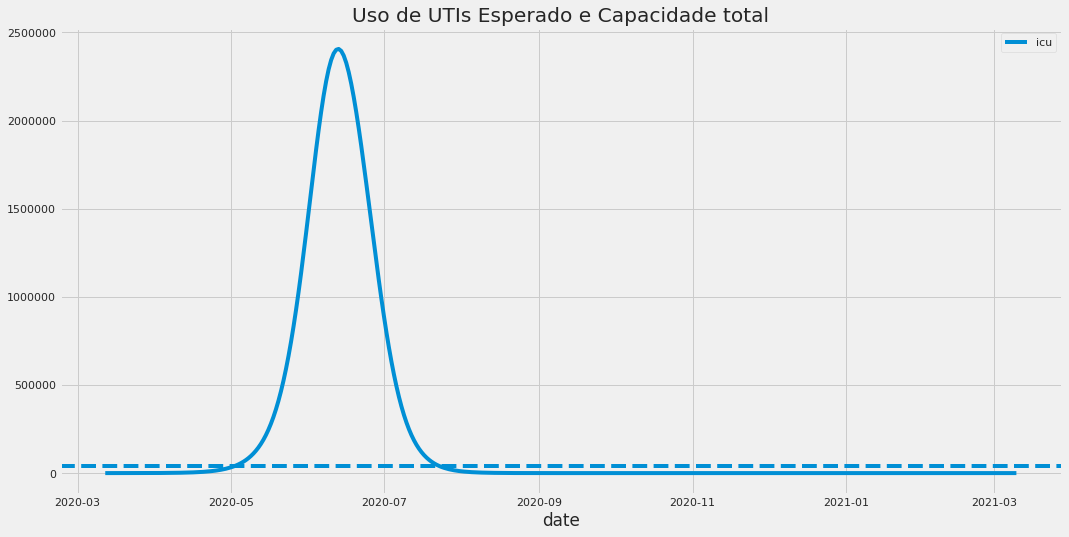

In [37]:
plot_simulation_output(df_simulated_data_by_date, zoom_on='2020-05-01')

In [38]:
df_simulation_data.tail()

,t,t_admitted,date,new_patients,er,hospitalized,icu,recovered,dead
66789,363,359,2021-03-10,0.0,0,4.552564e-13,1.517521e-13,0.0,0.0
66790,363,360,2021-03-10,0.0,0,3.887071e-13,1.295690e-13,0.0,0.0
66791,363,361,2021-03-10,0.0,0,3.318860e-13,1.106287e-13,0.0,0.0
66792,363,362,2021-03-10,0.0,0,2.833710e-13,9.445699e-14,0.0,0.0
66793,363,363,2021-03-10,0.0,0,2.419479e-13,8.064929e-14,0.0,0.0


In [39]:
df_simulated_data_by_date.tail()

,new_patients,er,hospitalized,icu,recovered,dead
date,,,,,,
2021-03-06,3.035043e-12,0,7.656603e-10,1.269639e-11,1.853084e+07,3.595537e+06
2021-03-07,2.591381e-12,0,7.651924e-10,1.084043e-11,1.853084e+07,3.595537e+06
2021-03-08,2.212573e-12,0,7.647929e-10,9.255782e-12,1.853084e+07,3.595537e+06
2021-03-09,1.889140e-12,0,7.644518e-10,7.902774e-12,1.853084e+07,3.595537e+06
2021-03-10,1.612986e-12,0,7.641605e-10,6.747549e-12,1.853084e+07,3.595537e+06


## Salvar Resultados

Finalmente, vamos salvar os resultados da simulação em um arquivo para possível uso posterior.

In [40]:
df_simulated_data_by_date.to_csv(results_folder + f'hospitalization_process_model_output.{target_location.lower()}.csv')